In [319]:
from collections import Counter

from scipy.stats import chi2_contingency
import scipy.linalg as la
import scipy.stats

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import normalize

np.set_printoptions(linewidth=np.inf)

Uvažujte model hromadné obsluhy 
M
∣
G
∣
∞


 - Požadavky přichází podle Poissonova procesu s intenzitou λ=10s−1

 - Doba obsluhy jednoho požadavku (v sekundách) má rozdělení S∼Ga(4,2), tj. Gamma s parametry a=4, p=2.

 - Časy mezi příchody a časy obsluhy jsou nezávislé.

 - Systém má (teoreticky) nekonečně paralelních obslužných míst (každý příchozí je rovnou obsluhován).

Označme  Nt počet zákazníků v systému v čase. Předpokládejme, že na začátku je systém prázdný, tj. N0 = 0.

## Úloha 1
Simulujte jednu trajektorii {Nt(ω)∣t∈(0,10 s)} Průběh trajektorie graficky znázorněte.

In [145]:
def simulate(T, G):
    N = [0]
    active = []
    
    for index_t, time in enumerate(T):
        N.append(N[-1] + 1)
        active.append(index_t)
        
        for index_g, gamma in enumerate(G):
            if index_g < index_t:
                if (T[index_g] + gamma <= time) and (index_g in active):
                    N[-1] -= 1
                    active.remove(index_g)
            else:
                break
        
    return N

In [184]:
lambd = 10
t_max = 10

p, a = 2, 4

# Pocet udalosti vygenerovany z Poissonovho rozdelenia s intenzitou lambda * tmax
n = np.random.poisson(lambd * t_max)

# Casy prichodu - vygenerujeme n uniformnych velicin od nuly po tmax, casy zoradime, pridame pociatocny cas 0, kedy je v systeme 0 poziadaviek
U = np.random.uniform(low=0, high=t_max, size=n)
G = np.random.gamma(p, 1/a, size=n)

T = sorted(list(U))

N = simulate(T, G)

if (T[-1] != n):
    T.append(10)
    N.append(N[-1])
    
T.insert(0, 0)

print(len(N))
print(N[:10])

107
[0, 1, 2, 3, 3, 4, 4, 2, 2, 3]


In [185]:
print(len(T))
print(T[:10])

107
[0, 0.023654269461971245, 0.14757208478584194, 0.21715479752666633, 0.2930152058596869, 0.41286074881164647, 0.589568196283301, 0.8918662591338844, 1.2431676470216146, 1.5121344873096831]


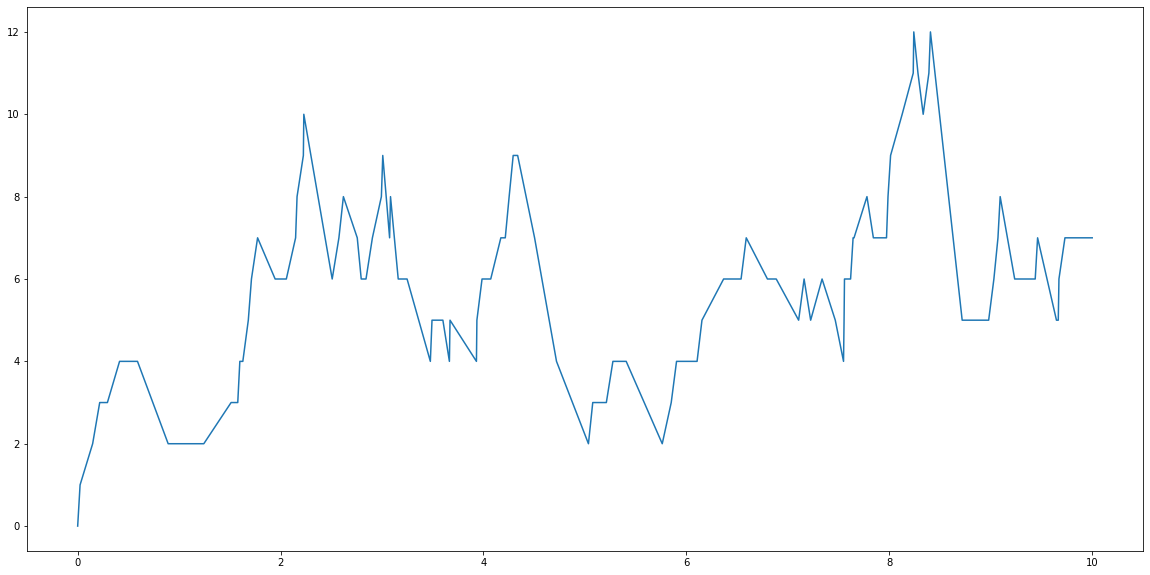

In [186]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

plt.plot(T, N)

## Úloha 2
Simulujte n=500 nezávislých trajektorií pro t∈(0,100). Na základě těchto simulací odhadněte rozdělení náhodné veličiny 
N100.

In [348]:
lambd = 10
t_max = 100

p, a = 2, 4

dist = {}

for i in range(0, 500):
    # Pocet udalosti vygenerovany z Poissonovho rozdelenia s intenzitou lambda * tmax
    n = np.random.poisson(lambd * t_max)

    # Times of arrival - vygenerujeme n uniformnych velicin od nuly po tmax, casy zoradime, pridame pociatocny cas 0
    # Kedy je v systeme 0 poziadaviek
    U = np.random.uniform(low=0, high=t_max, size=n)
    G = np.random.gamma(p, 1/a, size=n)

    T = sorted(list(U))

    N = simulate(T, G)

    if N[-1] not in dist:
        dist[N[-1]] = 1
    else:
        dist[N[-1]] += 1
        
print(dist)

{7: 74, 9: 34, 6: 85, 5: 83, 4: 70, 3: 39, 2: 21, 11: 7, 10: 23, 8: 53, 12: 6, 13: 2, 16: 1, 14: 1, 1: 1}


In [350]:
dist = {key: val / 500 for key, val in dist.items()}
dist = dict(sorted(dist.items()))
print(dist)

{1: 0.002, 2: 0.042, 3: 0.078, 4: 0.14, 5: 0.166, 6: 0.17, 7: 0.148, 8: 0.106, 9: 0.068, 10: 0.046, 11: 0.014, 12: 0.012, 13: 0.004, 14: 0.002, 16: 0.002}


In [351]:
# Make sure the probabilities sum up to one
sum(dist.values(), 0.0)

1.0000000000000002

## Úloha 3
Diskutujte, jaké je limitní rozdělení tohoto systému pro t→+∞. Pomocí vhodného testu otestujte na hladině významnosti 5 %, zda výsledky simulace N100 odpovídají tomuto rozdělení.

In [381]:
mu = 1 / scipy.stats.gamma.mean(p, loc=0, scale=1/a)
mu

2.0

In [383]:
poisson = {}
for key in dist.keys():
    poisson[key] = scipy.stats.poisson.pmf(key, lambd / mu)

poisson = dict(sorted(poisson.items()))

In [384]:
exp = list(poisson.values())
print(exp)

[0.03368973499542734, 0.08422433748856832, 0.1403738958142805, 0.17546736976785063, 0.17546736976785068, 0.1462228081398754, 0.10444486295705395, 0.06527803934815865, 0.036265577415643714, 0.018132788707821854, 0.008242176685373562, 0.0034342402855723226, 0.0013208616482970467, 0.0004717363029632305, 4.91391982253364e-05]


In [385]:
obs = list(dist.values())
print(obs)

[0.002, 0.042, 0.078, 0.14, 0.166, 0.17, 0.148, 0.106, 0.068, 0.046, 0.014, 0.012, 0.004, 0.002, 0.002]


In [386]:
scipy.stats.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=0.31762474675005664, pvalue=0.9999999995599753)

In [361]:
dof = len(obs) - 1
dof

14